<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/010_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow2.0教程-Pix2Pix

本教程使用条件GAN演示图像到图像的转换，如使用条件对抗网络的图像到图像转换中所述。使用这种技术，我们可以着色黑白照片，将谷歌地图转换为谷歌地球等。在这里，我们将建筑物外墙转换为真实建筑物。

在例子中，我们将使用CMP门面数据库，通过提供有益中心的机器感知在布拉格捷克技术大学。为了简化我们的示例，我们将使用由上述论文的作者创建的该数据集的预处理副本。



导入TensorFlow和其他库

In [1]:
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

加载数据集 您可以从此处下载此数据集和类似数据集。如本文所述，我们将随机抖动和镜像应用于训练数据集。

+ 在随机抖动中，图像被调整大小286 x 286，然后随机裁剪为256 x 256
+ 在随机镜像中，图像随机水平翻转，即从左到右。

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'
path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip),'facades/')

30171136/30168306 [==============================] - 6s 0us/step


In [3]:
print(PATH)

/root/.keras/datasets/facades/


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)  #将JPEG编码的图像解码为uint8张量。
  print(tf.shape(image))

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [6]:
inp, re = load(PATH+'train/100.jpg')

tf.Tensor([256 512   3], shape=(3,), dtype=int32)


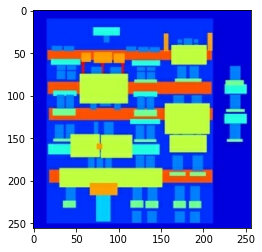

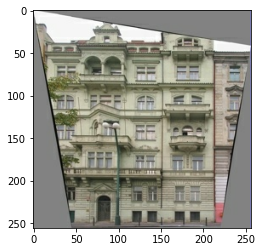

In [7]:
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [8]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [10]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [11]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

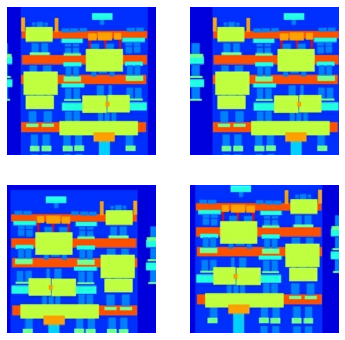

In [12]:

# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [13]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [14]:

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

输入管道

In [15]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

Tensor("Shape:0", shape=(3,), dtype=int32)


In [16]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
# shuffling so that for every epoch a different image is generated
# to predict and display the progress of our model.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

Tensor("Shape:0", shape=(3,), dtype=int32)


构建生成器
+ 生成器的架构是改进的U-Net。
+ 编码器中的每个块都是（Conv - > Batchnorm - > Leaky ReLU）
+ 解码器中的每个块是（Transposed Conv - > Batchnorm - > Dropout（应用于前3个块） - > ReLU）
+ 编码器和解码器之间存在跳过连接（如在U-Net中）。

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [19]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [20]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [21]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [22]:
def Generator():
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

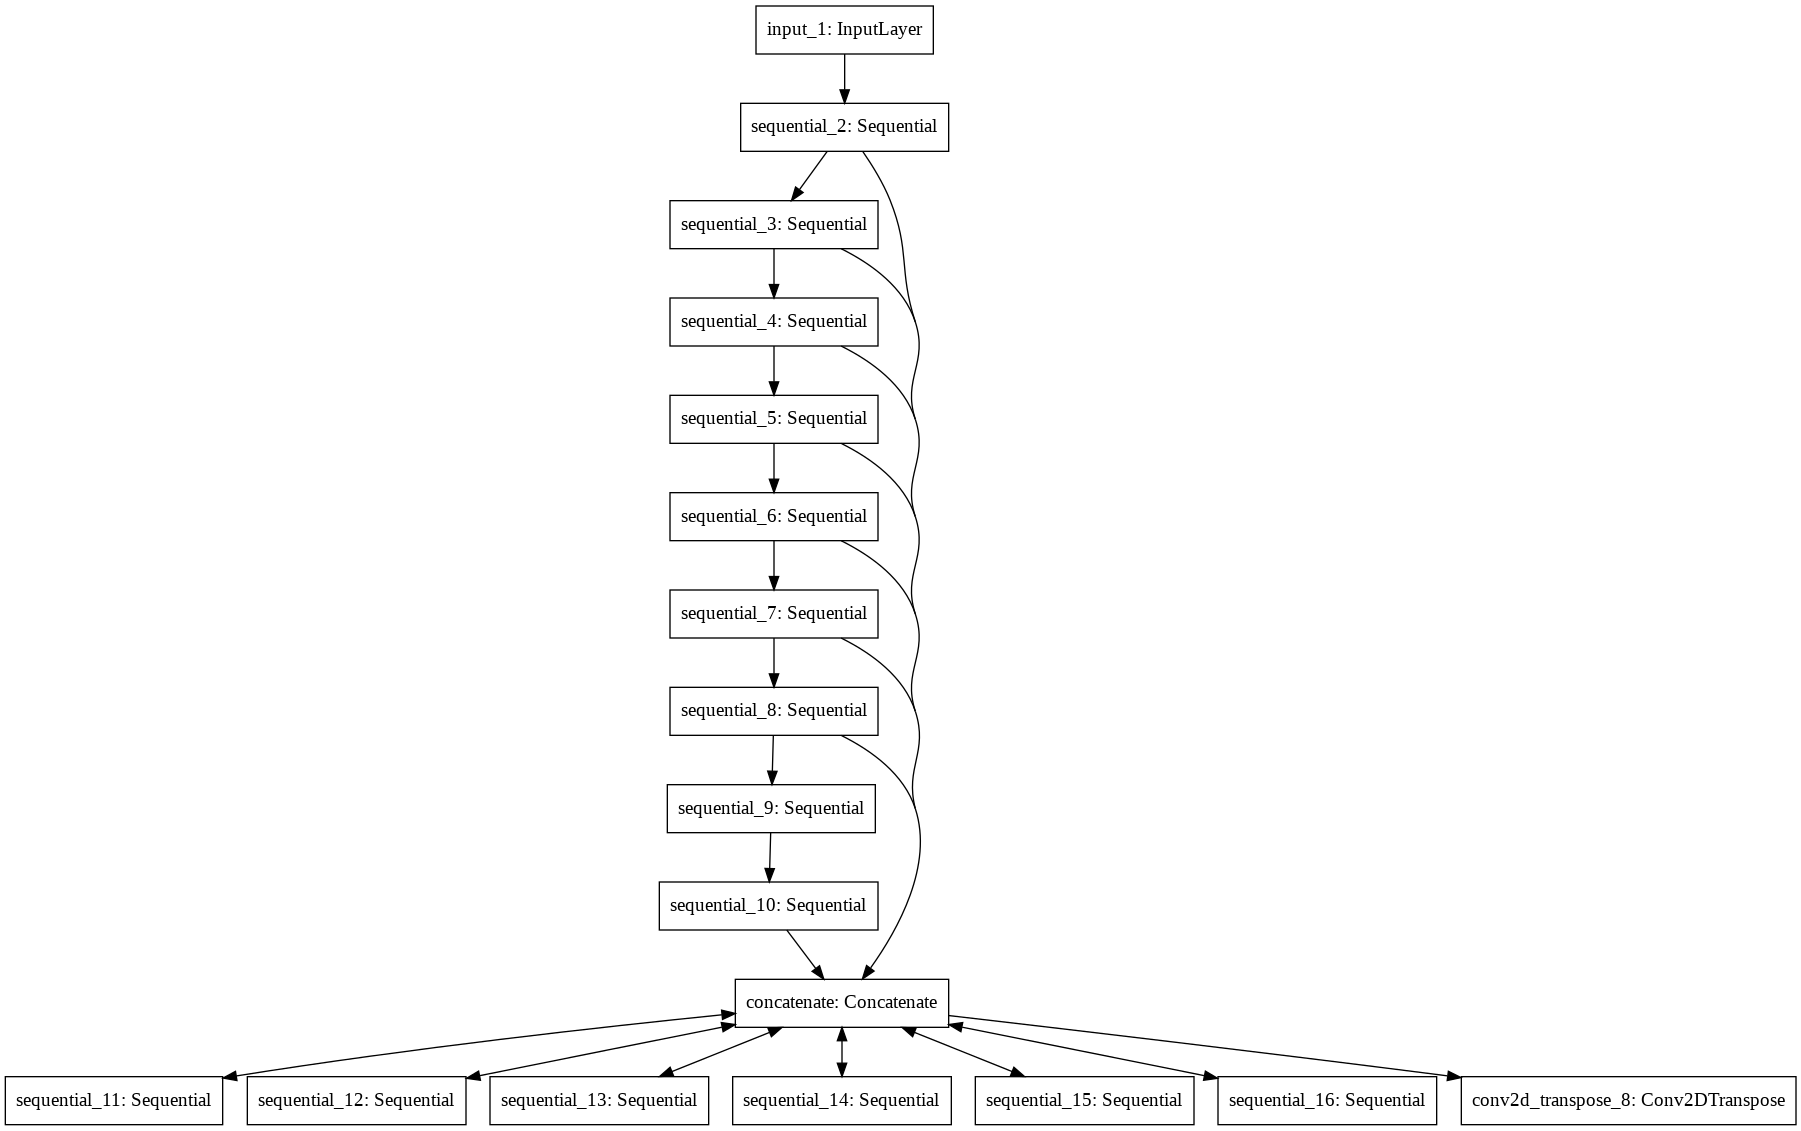

In [23]:
from keras.utils import plot_model
generator = Generator()
# generator.summary()
plot_model(generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


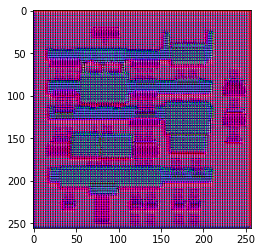

In [24]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

建立判别器
+ 鉴别器是PatchGAN。
+ 鉴别器中的每个块都是（Conv - > BatchNorm - > Leaky ReLU）
+ 最后一层之后的输出形状为（batch_size，30,30,1）
+ 输出的每个30x30补丁分类输入图像的70x70部分（这种架构称为PatchGAN）。
+ 鉴别器接收2个输入。
  + 输入图像和目标图像，它应该归类为真实的。
  + 输入图像和生成的图像（生成器的输出），它应该归类为伪造的。
  + 我们在代码（tf.concat([inp, tar], axis=-1)）中将这两个输入连接在一起

In [25]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

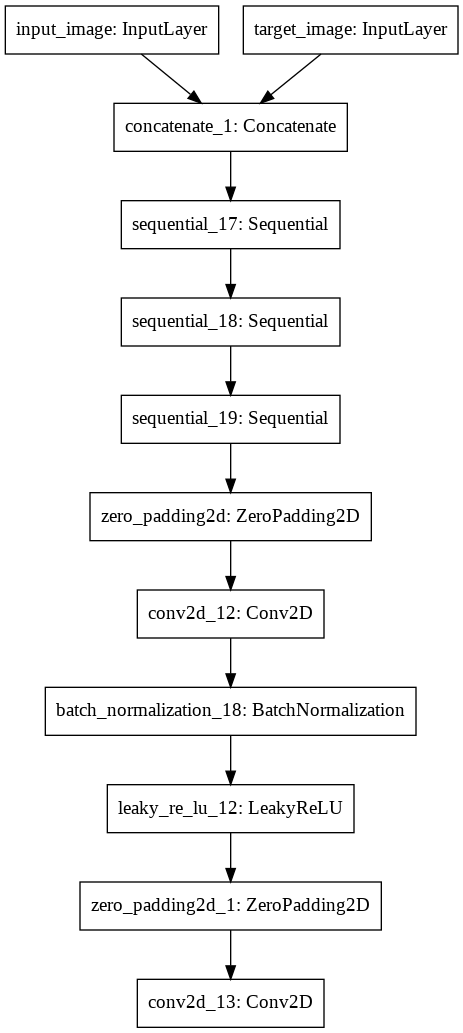

In [26]:
discriminator = Discriminator()
plot_model(discriminator)

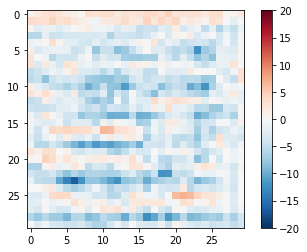

In [27]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## 定义损失函数和优化程序
+ 判别器损失
 + 鉴别器丢失功能需要2个输入; 真实图像，生成图像
 + real_loss是真实图像的sigmoid交叉熵损失和一个数组（因为这些是真实的图像）
 + generated_loss是生成的图像的sigmoid交叉熵丢失和零的数组（因为这些是伪图像）
 + 然后total_loss是real_loss和generated_loss的总和

+ 生成器损失
 + 它是生成的图像的sigmoid交叉熵损失和一组数组。
 + 该论文还包括L1损失，其是生成的图像和目标图像之间的MAE（平均绝对误差）。
 + 这允许生成的图像在结构上变得类似于目标图像。
 + 式来计算总发电机损失= gan_loss + LAMBDA * l1_loss，其中LAMBDA = 100。这个值是由的作者决定。

In [28]:
LAMBDA = 100

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [31]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [32]:

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

检查点（基于对象的保存）

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

训练
+ 我们首先迭代数据集
+ 生成器获取输入图像，我们得到生成的输出。
+ 鉴别器接收input_image和生成的图像作为第一输入。第二个输入是input_image和target_image。
+ 接下来，我们计算生成器和鉴别器损耗。
+ 然后，我们计算相对于生成器和鉴别器变量（输入）的损耗梯度，并将它们应用于优化器。


生成图像
+ 经过培训，它有时间生成一些图像！
+ 我们将图像从测试数据集传递到生成器。
+ 然后，生成器将输入图像转换为我们期望的输出。
+ 最后一步是绘制预测和瞧！

In [34]:
EPOCHS = 150

In [35]:
def generate_images(model, test_input, tar):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [36]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [37]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:
      train_step(input_image, target)

    clear_output(wait=True)
    for inp, tar in test_dataset.take(1):
      generate_images(generator, inp, tar)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

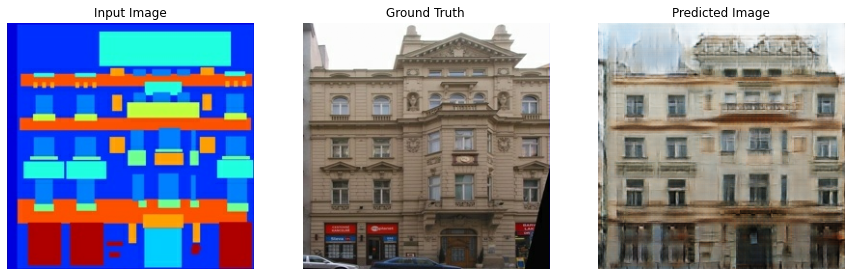

Time taken for epoch 150 is 36.57017183303833 sec



In [38]:
train(train_dataset, EPOCHS)

恢复最新的检查点并进行测试

In [39]:
!ls {checkpoint_dir}

checkpoint		    ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-1.index		    ckpt-5.index
ckpt-2.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-2.index		    ckpt-6.index
ckpt-3.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-3.index		    ckpt-7.index
ckpt-4.data-00000-of-00001


In [40]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

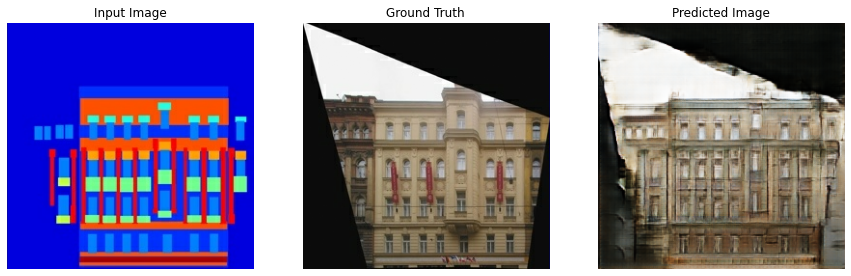

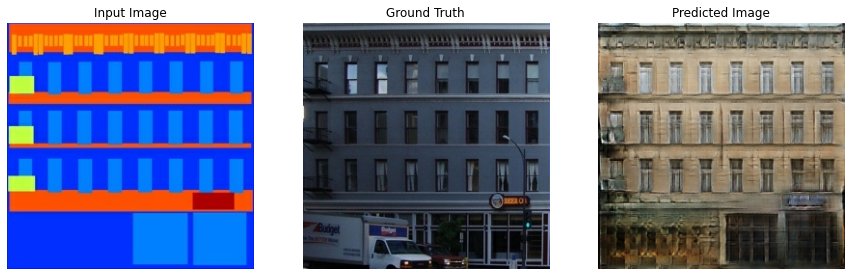

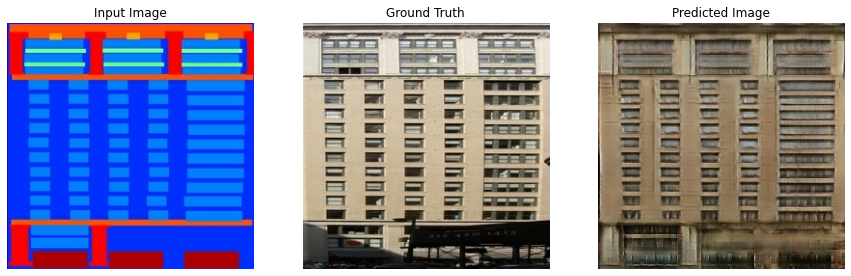

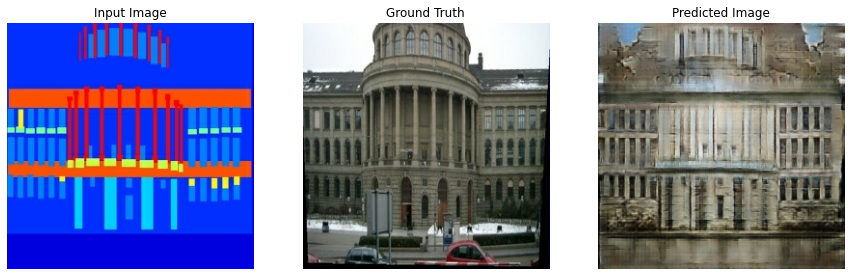

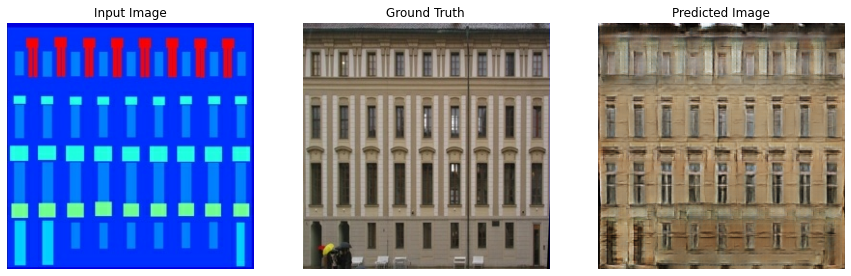

In [41]:

# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)